### Starbucks Capstone Challenge
# Recurrent Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models import RecurrentNN

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


In [3]:
recurrent_classifier = RecurrentNN(
    input_size=16,
    hidden_size=128,
    hidden_layers=2,
    output_size=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(recurrent_classifier.parameters(),
                       lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=100, verbose=True)

In [4]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        POS, NEG = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        valid_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            targets = targets.view(-1)
            positive = targets == 1
            negative = ~positive

            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            valid_loss += criterion(prediction, targets)

            prediction = torch.sigmoid(prediction)
            prediction = prediction.round()

            ## Compare prediction with target POSITIVE
            POS += positive.sum()
            # Target TRUE, Prediction TRUE --> True Positive
            TP += targets[positive].eq(prediction[positive]).sum()

            ## Compare prediction with target NEGATIVE
            NEG += negative.sum()
            # Target FALSE, Prediction FALSE --> True Negative
            TN += targets[negative].eq(prediction[negative]).sum()

        FN += POS - TP # Target TRUE, Prediction FALSE --> False Negative
        FP += NEG - TN # Target FALSE, Prediction TRUE --> False Positive

        # normalize the loss
        valid_loss /= batch
        
        print(f'\n\tValidation ... loss: {valid_loss:7.4f}')
        print(f'\t\tTP: {TP:4d}\tFP: {FP:4d}\tOP: {TP+FP:4d}')
        print(f'\t\tFN: {FN:4d}\tTN: {TN:4d}\tON: {TN+FN:4d}')
        print(f'\t\tCP: {POS:4d}\tCN: {NEG:4d}')
        print('\tAccuracy: {:5.2f}%\tPrecision: {:5.2f}\tRecall: {:5.2f}\n'
              .format((TP+TN)/float(POS+NEG)*100,
                      TP/float(TP+FP), TP/float(TP+FN)))

        model.train()

In [5]:
def train(model, dataloader=train_dataloader, epochs=5000):
    train_loss = []
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0

        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the loss
        epoch_loss /= batch
        train_loss.append(epoch_loss)
        lr_scheduler.step(train_loss[-1])

        print('Epoch {:4d}\ttraining loss: {:7.4f}' \
              .format(epoch, train_loss[-1]))
        if epoch % 10 == 0:
            validate(model)

    print('\n')
    return train_loss

Epoch    1	training loss:  0.6556
Epoch    2	training loss:  0.6290
Epoch    3	training loss:  0.6247
Epoch    4	training loss:  0.6234
Epoch    5	training loss:  0.6232
Epoch    6	training loss:  0.6228
Epoch    7	training loss:  0.6221
Epoch    8	training loss:  0.6219
Epoch    9	training loss:  0.6211
Epoch   10	training loss:  0.6210

	Validation ... loss:  0.6330
		TP: 2512	FP: 1559	OP: 4071
		FN: 1773	TN: 3696	ON: 5469
		CP: 4285	CN: 5255
	Accuracy: 65.07%	Precision:  0.62	Recall:  0.59

Epoch   11	training loss:  0.6212
Epoch   12	training loss:  0.6204
Epoch   13	training loss:  0.6197
Epoch   14	training loss:  0.6181
Epoch   15	training loss:  0.6172
Epoch   16	training loss:  0.6163
Epoch   17	training loss:  0.6137
Epoch   18	training loss:  0.6120
Epoch   19	training loss:  0.6094
Epoch   20	training loss:  0.6084

	Validation ... loss:  0.6190
		TP: 2570	FP: 1526	OP: 4096
		FN: 1715	TN: 3729	ON: 5444
		CP: 4285	CN: 5255
	Accuracy: 66.03%	Precision:  0.63	Recall:  0.60

Ep

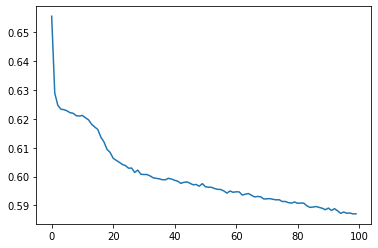

In [6]:
train_loss = train(recurrent_classifier, epochs=100)
plt.plot(train_loss)
plt.show()

In [7]:
validate(recurrent_classifier, test_dataloader)


	Validation ... loss:  0.5908
		TP: 2689	FP: 1368	OP: 4057
		FN: 1598	TN: 3879	ON: 5477
		CP: 4287	CN: 5247
	Accuracy: 68.89%	Precision:  0.66	Recall:  0.63

